In [2]:
import datetime

import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import abline_plot

In [3]:
timedelta = datetime.timedelta(365 * 3)  # 3 years
start = datetime.datetime.today() - timedelta
end = datetime.datetime.today()
df_raw = yf.download(["BTC-USD", "ETH-USD"], start, end)

[*********************100%%**********************]  2 of 2 completed


In [4]:
df = pd.DataFrame({"BTC":df_raw["Adj Close"]["BTC-USD"], "ETH":df_raw["Adj Close"]["ETH-USD"]}, index=df_raw.index)  # Use a  dict  as the first argument in pd.DataFrame()  !!!!!!!
df.head(10)

,BTC,ETH
Date,,
2020-11-16,16716.111328,459.940308
2020-11-17,17645.406250,480.360077
2020-11-18,17804.005859,479.484070
2020-11-19,17817.089844,471.630432
2020-11-20,18621.314453,509.744568
2020-11-21,18642.232422,549.486633
2020-11-22,18370.001953,558.068115
2020-11-23,18364.121094,608.454041
2020-11-24,19107.464844,603.897766


In [5]:
# Calculate log returns
df["BTC_lr"] = np.log(df["BTC"] / df["BTC"].shift(1))
df["ETH_lr"] = np.log(df["ETH"] / df["ETH"].shift(1))
df = df.iloc[1:, :]
df.head(10)

,BTC,ETH,BTC_lr,ETH_lr
Date,,,,
2020-11-17,17645.406250,480.360077,0.054102,0.043439
2020-11-18,17804.005859,479.484070,0.008948,-0.001825
2020-11-19,17817.089844,471.630432,0.000735,-0.016515
2020-11-20,18621.314453,509.744568,0.044149,0.077714
2020-11-21,18642.232422,549.486633,0.001123,0.075075
2020-11-22,18370.001953,558.068115,-0.014711,0.015497
2020-11-23,18364.121094,608.454041,-0.000320,0.086440
2020-11-24,19107.464844,603.897766,0.039680,-0.007516
2020-11-25,18732.121094,570.686646,-0.019839,-0.056565


Now we are going to model a **WLS** regression with **BTC** log returns as the predictor (independent) variable and **ETH** log returns as the dependent variable.

* First we run an **OLS** model to get coefficient estimates $\beta_0, \beta_1$ and residuals $r_i = \hat{y_i} - y_i$

In [6]:
# Fit the OLS model using statsmodels formula api
model_ols = smf.ols("ETH_lr ~ BTC_lr", df).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ETH_lr   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     2237.
Date:                Thu, 16 Nov 2023   Prob (F-statistic):          1.09e-266
Time:                        13:56:26   Log-Likelihood:                 2457.1
No. Observations:                1095   AIC:                            -4910.
Df Residuals:                    1093   BIC:                            -4900.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006      0.001      0.740      0.459      -0.001       0.002
BTC_lr         1.0722      0.023     47.300      0.000       1.028       1.117
==============================================================================
Omnibus:                      267.925   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2846.343
Skew:                           0.806   Prob(JB):                         0.00
Kurtosis:                      10.732   Cond. No.                         29.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our OLS model is the following:

$\beta_0 = 0.0006 $

$\beta_1 = 1.0722 $

$Y_i = 0.0006 + 1.0722 x_i + \epsilon_i$

where,

$Y_i:$ Daily log return of **ETH** in observation $i$, which is a **random variable**

$x_i:$ Realized value of daily log return of **BTC** in observation $i$, which is a known **constant** 

$\epsilon_i :$ Error term of observation $i$, which is a **random variable** assumed to be normally distributed: $e_i$ ~ $N(0, \sigma_i^2)$

Please note the following properties of $Y_i$:

$E[Y_i] = 0.0006 + 1.0722 x_i$

 and the distribution 
 
 $Y_i$ ~ $N(0.0006 + 1.0722 x_i, \quad \sigma_i^2)$

Let's generate a plot to better understand our OLS fit and data:

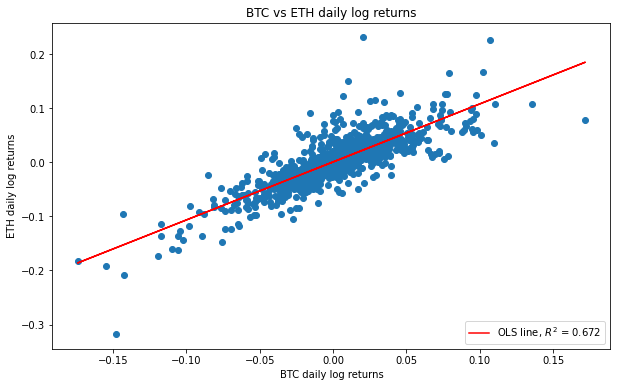

In [7]:
# Plot the data and the OLS regression line
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df["BTC_lr"], df["ETH_lr"])
ax.plot(df["BTC_lr"], 0.0006 + 1.0722 * df["BTC_lr"], color="red", label="OLS line, $R^2$ = 0.672")
ax.set(xlabel="BTC daily log returns", ylabel="ETH daily log returns", title="BTC vs ETH daily log returns")
ax.legend(loc="lower right")

Now, let's use **Breusch-Pagan** test to test our data for **homoscedasticity** (variance of the different error terms $e_i$ are the same and constant). Remember, if the $p$ value from our test result comes $p < 0.05$ then we reject the null hypothesis that our error terms are **homoscedastic** and we will try to solve the **heteroscedasticity** problem with a **WLS** (Weighted least squares) model.

In [8]:
# Breusch-Pagan Test
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]

# test uses residuals as dependent variables and x_i values as predictor variables
test = sms.het_breuschpagan(model_ols.resid, model_ols.model.exog)
pd.DataFrame(test, index=name, columns=[""])

,
Lagrange multiplier statistic,1.769363
p-value,0.183461
f-value,1.768990
f p-value,0.183785


Our $p$ value came of as $p > 0.05$ which means our error terms can be considered **homoscedastic** (same and constant variance) which means:

$Var(e_1) = Var(e_2) = Var(e_n) = \sigma^2$

This means we don't need to model the **error terms** $e_i$ as a function of $y_i$ or $x_i$ and assume error term variance $\sigma^2$ is **independent** from our predictor variables $x_i$ or dependent variables $y_i$.

Then, let's fit a **WLS** regression model to reduce the weights of outliers in our data:

* First we calculate weights $(w_i)$ using the residuals from our previous **OLS** model:

$w_i = \Large\frac{1}{\hat{Var(\epsilon_i)}} = \Large\frac{1}{\hat{\sigma_i^2}}$

* To estimate the **variance** of $\epsilon_i$ we can first plot the **residuals** from OLS $r_i$ against **fitted values** $\hat{y_i}$ to have a visual idea:

[Text(0.5, 0, '$\\hat{y_i}$'),
 Text(0, 0.5, '$r_i = y_i - \\hat{y_i}$'),
 Text(0.5, 1.0, 'Residuals vs Fitted values')]

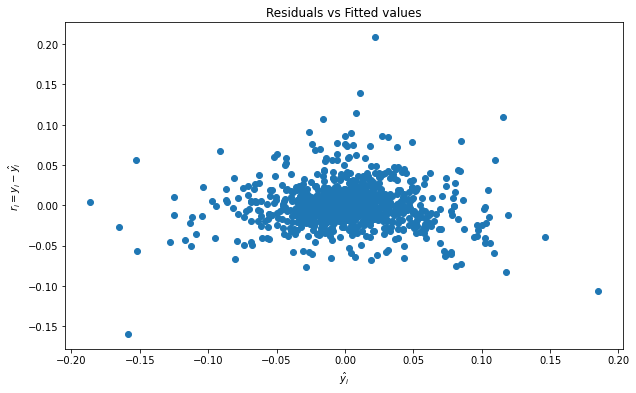

In [9]:
residuals_OLS = model_ols.resid
fitted_values_OLS = model_ols.fittedvalues

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(fitted_values_OLS, residuals_OLS)
ax.set(xlabel = "$\hat{y_i}$", ylabel = "$r_i = y_i - \hat{y_i}$", title = "Residuals vs Fitted values")

It seems like absolute value of residuals are slightly increasing with increasing $\hat{y_i}$ values. Then, we can try to fit an OLS model with absolute value of residuals $|r_i|$ as the dependent (endogenous) variable and fitted values $\hat{y_i}$ as predictor (exogenous) variables:

In [10]:
# Fit an OLS model to predict abs value of residuals, predictor: fitted values y_i^
df["abs_residuals"] = abs(model_ols.resid)
df["fitted_values"] = model_ols.fittedvalues
model_absresid = smf.ols("abs_residuals ~ fitted_values", df).fit()
model_absresid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          abs_residuals   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.964
Date:                Thu, 16 Nov 2023   Prob (F-statistic):             0.0148
Time:                        13:56:27   Log-Likelihood:                 2780.4
No. Observations:                1095   AIC:                            -5557.
Df Residuals:                    1093   BIC:                            -5547.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0170      0.001     29.449      0.000       0.016       0.018
fitted_values     0.0384      0.016      2.442      0.015       0.008       0.069
==============================================================================
Omnibus:                      758.039   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13157.317
Skew:                           2.977   Prob(JB):                         0.00
Kurtosis:                      18.903   Cond. No.                         27.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here we get $\hat{\sigma_i^2}$ as a function of $\hat{y_i}$ :

$\hat{\sigma_i^2} = 0.0170 + 0.0384 \hat{y_i}$

Although this is a very bad fit with $R^2 = 0.005$, let's proceed to calculate weights and fit a WLS model just for practice.

We are going to choose our weights as :

$w_i = \Large\frac{1}{\hat{\sigma_i^2}}$

In [11]:
# Calculate weights
weights = model_absresid.fittedvalues ** -2
df["weights"] = weights
df.head(10)

,BTC,ETH,BTC_lr,ETH_lr,abs_residuals,fitted_values,weights
Date,,,,,,,
2020-11-17,17645.406250,480.360077,0.054102,0.043439,0.015145,0.058584,2691.523476
2020-11-18,17804.005859,479.484070,0.008948,-0.001825,0.011994,0.010169,3297.382938
2020-11-19,17817.089844,471.630432,0.000735,-0.016515,0.017877,0.001362,3429.381116
2020-11-20,18621.314453,509.744568,0.044149,0.077714,0.029803,0.047911,2809.829006
2020-11-21,18642.232422,549.486633,0.001123,0.075075,0.073296,0.001778,3422.967157
2020-11-22,18370.001953,558.068115,-0.014711,0.015497,0.030695,-0.015198,3700.041277
2020-11-23,18364.121094,608.454041,-0.000320,0.086440,0.086209,0.000231,3446.905497
2020-11-24,19107.464844,603.897766,0.039680,-0.007516,0.050637,0.043120,2865.491416
2020-11-25,18732.121094,570.686646,-0.019839,-0.056565,0.035867,-0.020697,3797.035771


* After this, we use the weights to fit a **WLS** regression:

In [12]:
# Model a WLS regression
Y = df["ETH_lr"].tolist()
X = df["BTC_lr"].tolist()
X = sm.add_constant(X)  # add an intercept point
model_wls = sm.WLS(Y, X, weights=weights).fit()
model_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.719
Model:                            WLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     2803.
Date:                Thu, 16 Nov 2023   Prob (F-statistic):          5.75e-304
Time:                        13:56:27   Log-Likelihood:                 2440.5
No. Observations:                1095   AIC:                            -4877.
Df Residuals:                    1093   BIC:                            -4867.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.782      0.434      -0.001       0.002
x1             1.1315      0.021     52.947      0.000       1.090       1.173
==============================================================================
Omnibus:                      227.060   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5356.631
Skew:                           0.293   Prob(JB):                         0.00
Kurtosis:                      13.820   Cond. No.                         27.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As you can see, we slightly improved our $R^2$ value from 0.672 to $R^2 = 0.719$. For visualization, let's compare our two **OLS** and **WLS** lines:

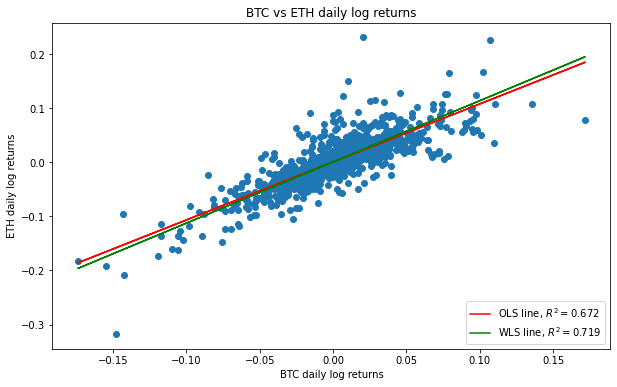

In [13]:
# Plot the data and the OLS and WLS regression line
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df["BTC_lr"], df["ETH_lr"])
ax.plot(df["BTC_lr"], 0.0006 + 1.0722 * df["BTC_lr"], color="red", label="OLS line, $R^2 = 0.672$")
ax.plot(df["BTC_lr"], 0.0006 + 1.1315 * df["BTC_lr"], color="green", label="WLS line, $R^2 = 0.719$")
ax.set(xlabel="BTC daily log returns", ylabel="ETH daily log returns", title="BTC vs ETH daily log returns")
ax.legend(loc="lower right")